In [2]:
# 导入数据
# 对比四个简单的分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# select k best features
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [32]:
# 读取数据
tongji_rad = pd.read_csv('./feature/tongji/rad_feature.csv', index_col=0).iloc[:, 37:]
tongji_label = pd.read_csv('./feature/tongji/tongji.csv', index_col=0)

xiangyang_rad = pd.read_csv('./feature/xiangyang/rad_feature.csv', index_col=0).iloc[:, 37:]
xiangyang_label = pd.read_csv('./feature/xiangyang/xiangyang.csv', index_col=0)

# 合并数据表格
feature_rad = pd.concat([tongji_rad, xiangyang_rad], axis=0)
label = pd.concat([tongji_label, xiangyang_label], axis=0)

# 读取两个验证集的数据
kits_rad = pd.read_csv('./feature/kits/rad_feature.csv', index_col=0).iloc[:, 37:]
kits_label = pd.read_csv('./feature/kits/kits.csv', index_col=0)
henan_rad = pd.read_csv('./feature/henan/rad_feature.csv', index_col=0).iloc[:, 37:]
henan_label = pd.read_csv('./feature/henan/henan.csv', index_col=0)

# 按照index排序
feature_rad = feature_rad.sort_index()
label = label.sort_index()

kits_rad = kits_rad.sort_index()
kits_label = kits_label.sort_index()

henan_rad = henan_rad.sort_index()
henan_label = henan_label.sort_index()

assert all(feature_rad.index == label.index)
assert all(kits_rad.index == kits_label.index)
assert all(henan_rad.index == henan_label.index)

# 定义 X_train, y_train, X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(feature_rad, label, test_size=0.3, random_state=42)
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_henan = pd.DataFrame(scaler.transform(henan_rad), index=henan_rad.index, columns=henan_rad.columns)
X_kits = pd.DataFrame(scaler.transform(kits_rad), index=kits_rad.index, columns=kits_rad.columns)
y_henan = henan_label
y_kits = kits_label
assert all(X_kits.index == y_kits.index)
assert all(X_henan.index == y_henan.index)
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_henan = y_henan.values.ravel()
y_kits = y_kits.values.ravel()
# print(X_train.shape, y_train.shape)

In [33]:
import numpy as np
from sklearn.metrics import roc_curve, precision_score, recall_score

def find_best_threshold_by_youden(y_true, y_scores):
    """
    使用约登指数确定最佳分类阈值，并计算相应的精确率和召回率。

    参数:
    -------
    y_true : array-like of shape (n_samples,)
        真实的二分类标签（0和1）。
    y_scores : array-like of shape (n_samples,)
        预测为正类的概率分数。

    返回:
    -------
    best_threshold : float
        通过约登指数确定的最佳阈值。
    precision : float
        使用最佳阈值计算的精确率。
    recall : float
        使用最佳阈值计算的召回率。
    """
    # 计算ROC曲线的假阳性率、真阳性率和阈值
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # 计算约登指数
    youden_index = tpr - fpr
    
    # 找到最大约登指数对应的阈值索引
    best_idx = np.argmax(youden_index)
    best_threshold = thresholds[best_idx]
    
    # 根据最佳阈值生成预测标签
    y_pred = (y_scores >= best_threshold).astype(int)
    
    # 计算精确率和召回率
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print(f"最佳阈值 (Youden's Index)：{best_threshold:.4f}")
    print(f"精确率 (Precision)：{precision:.4f}")
    print(f"召回率 (Recall)：{recall:.4f}")
    
    return best_threshold, precision, recall

In [36]:
import warnings
warnings.filterwarnings('ignore')

# 定义分类器
classifiers = [
    ('logistic_regression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    # ('decision_tree', DecisionTreeClassifier(class_weight='balanced')),
    # ('random_forest', RandomForestClassifier(class_weight='balanced')),
    # ('linear_svm', LinearSVC(class_weight='balanced', max_iter=2000))  # 改用LinearSVC
]

# 存储结果
results = []

# 创建管道和网格搜索
for k_num in range(20,50,2):
    for clf_name, clf in classifiers:
        # 定义特征选择器
        feature_selector = SelectKBest(mutual_info_classif, k=k_num)
        
        # 创建管道
        pipeline = Pipeline([
            ('feature_selection', feature_selector),
            ('classifier', clf)
        ])
        
        # 定义参数网格
        param_grid = {
            'logistic_regression': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l1', 'l2', 'elasticnet'] 
            },
            'decision_tree': {
                'classifier__max_depth': [3, 5, 7, 10],
                'classifier__min_samples_split': [2, 5, 10]
            },
            'random_forest': {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [3, 5, 7],
                'classifier__min_samples_split': [2, 5, 10]
            },
            'linear_svm': {  # 修改SVM的参数
                'classifier__C': [0.1, 1, 10],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__dual': [False]  # 当使用l1正则化时，dual必须为False
            }
        }
        
        # 根据分类器名称选择对应的参数网格
        current_param_grid = param_grid[clf_name]
        
        # 创建网格搜索
        grid_search = GridSearchCV(
            pipeline,
            param_grid=current_param_grid,
            cv=5,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            refit='roc_auc',
            n_jobs=-1
        )
        
        # 训练模型
        grid_search.fit(X_train, y_train)
        
        # 在验证集上评估
        y_val_pred = grid_search.predict(X_val)
        y_val_pred_proba = grid_search.predict_proba(X_val)[:, 1]
        # print(y_val_pred_proba)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        # 对于LinearSVC，需要使用decision_function而不是predict_proba
        val_auc = roc_auc_score(y_val, grid_search.decision_function(X_val) if clf_name == 'linear_svm' 
                               else grid_search.predict_proba(X_val)[:, 1])
        
        # 在外部验证集上评估
        y_henan_pred = grid_search.predict(X_henan)
        henan_accuracy = accuracy_score(y_henan, y_henan_pred)
        henan_precision = precision_score(y_henan, y_henan_pred)
        henan_recall = recall_score(y_henan, y_henan_pred)
        henan_f1 = f1_score(y_henan, y_henan_pred)
        henan_auc = roc_auc_score(y_henan, grid_search.decision_function(X_henan) if clf_name == 'linear_svm'
                                 else grid_search.predict_proba(X_henan)[:, 1])
        
        y_kits_pred = grid_search.predict(X_kits)
        kits_accuracy = accuracy_score(y_kits, y_kits_pred)
        kits_precision = precision_score(y_kits, y_kits_pred)
        kits_recall = recall_score(y_kits, y_kits_pred)
        kits_f1 = f1_score(y_kits, y_kits_pred)
        kits_auc = roc_auc_score(y_kits, grid_search.decision_function(X_kits) if clf_name == 'linear_svm'
                                else grid_search.predict_proba(X_kits)[:, 1])
        
        # 存储结果
        results.append({
            'feature_num': k_num,
            'classifier': clf_name,
            'best_params': grid_search.best_params_,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'val_auc': val_auc,
            'henan_accuracy': henan_accuracy,
            'henan_precision': henan_precision,
            'henan_recall': henan_recall,
            'henan_f1': henan_f1,
            'henan_auc': henan_auc,
            'kits_accuracy': kits_accuracy,
            'kits_precision': kits_precision,
            'kits_recall': kits_recall,
            'kits_f1': kits_f1,
            'kits_auc': kits_auc
        })

In [38]:
print(results)
# 保存结果到CSV文件
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

[{'feature_num': 20, 'classifier': 'logistic_regression', 'best_params': {'classifier__C': 1, 'classifier__penalty': 'l2'}, 'val_accuracy': 0.7184466019417476, 'val_precision': 0.15254237288135594, 'val_recall': 0.5294117647058824, 'val_f1': 0.23684210526315788, 'val_auc': 0.6993464052287581, 'henan_accuracy': 0.6875, 'henan_precision': 0.2653061224489796, 'henan_recall': 0.2765957446808511, 'henan_f1': 0.27083333333333337, 'henan_auc': 0.5267460031253756, 'kits_accuracy': 0.6094420600858369, 'kits_precision': 0.22772277227722773, 'kits_recall': 0.6388888888888888, 'kits_f1': 0.33576642335766427, 'kits_auc': 0.668076706147772}, {'feature_num': 25, 'classifier': 'logistic_regression', 'best_params': {'classifier__C': 0.01, 'classifier__penalty': 'l2'}, 'val_accuracy': 0.7038834951456311, 'val_precision': 0.20270270270270271, 'val_recall': 0.8823529411764706, 'val_f1': 0.3296703296703297, 'val_auc': 0.8151260504201681, 'henan_accuracy': 0.6741071428571429, 'henan_precision': 0.3289473684

In [47]:
# 定义分类器
classifiers = LogisticRegression(max_iter=1000, class_weight='balanced')

k_num = 30
feature_selector = SelectKBest(mutual_info_classif, k=k_num)

param_grid = {'logistic_regression': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l1', 'l2', 'elasticnet'] 
            }
}
# 创建管道
pipeline = Pipeline([
    ('feature_selection', feature_selector),
    ('classifier', classifiers)
])
# 根据分类器名称选择对应的参数网格
current_param_grid = param_grid['logistic_regression']

# 创建网格搜索
grid_search = GridSearchCV(
    pipeline,
    param_grid=current_param_grid,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='roc_auc',
    n_jobs=-1
)

# 训练模型
grid_search.fit(X_train, y_train)

# 在验证集上评估
y_val_pred = grid_search.predict(X_val)
y_val_pred_proba = grid_search.predict_proba(X_val)[:,1]

val_auc = roc_auc_score(y_val, grid_search.decision_function(X_val) if clf_name == 'linear_svm' 
                        else grid_search.predict_proba(X_val)[:, 1])
print(val_auc)

# 在外部验证集上评估
y_henan_pred = grid_search.predict(X_henan)
y_henan_pred_proba = grid_search.predict_proba(X_henan)[:, 1]

y_kits_pred = grid_search.predict(X_kits)
y_kits_pred_proba = grid_search.predict_proba(X_kits)[:, 1]

# 存储结果
val_result = pd.DataFrame({
    'val_index': X_val.index,
    'y_val': y_val,
    'y_val_pred_proba': y_val_pred_proba
})
val_result.to_csv('val_result.csv', index=False)

henan_result = pd.DataFrame({
    'henan_index': X_henan.index,
    'y_henan': y_henan,
    'y_henan_pred_proba': y_henan_pred_proba
})
henan_result.to_csv('henan_result.csv', index=False)

kits_result = pd.DataFrame({
    
    'kits_index': X_kits.index,
    'y_kits': y_kits,
    'y_kits_pred_proba': y_kits_pred_proba

})
kits_result.to_csv('kits_result.csv', index=False)
        

0.8194833488951137


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats

def calculate_auc_ci(y_true, y_pred, n_bootstraps=1000, confidence_level=0.95):
    """
    计算AUC及其置信区间
    
    参数:
    y_true: 真实标签
    y_pred: 预测概率
    n_bootstraps: 重采样次数
    confidence_level: 置信水平
    
    返回:
    auc: AUC值
    ci_lower: 置信区间下界
    ci_upper: 置信区间上界
    """
    n_samples = len(y_true)
    auc_scores = []
    
    # 原始AUC
    original_auc = roc_auc_score(y_true, y_pred)
    
    # Bootstrap采样计算置信区间
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        # 有放回抽样
        indices = rng.randint(0, n_samples, n_samples)
        sample_true = y_true.iloc[indices] if isinstance(y_true, pd.Series) else y_true[indices]
        sample_pred = y_pred.iloc[indices] if isinstance(y_pred, pd.Series) else y_pred[indices]
        
        if len(np.unique(sample_true)) < 2:
            continue
        
        auc_scores.append(roc_auc_score(sample_true, sample_pred))
    
    # 计算置信区间
    alpha = (1 - confidence_level) / 2
    ci_lower = np.percentile(auc_scores, alpha * 100)
    ci_upper = np.percentile(auc_scores, (1 - alpha) * 100)
    
    return original_auc, ci_lower, ci_upper

# def plot_roc_with_ci(gt, proba, n_bootstraps=1000):
#     """
#     绘制ROC曲线及AUC置信区间
#     """
#     # 计算AUC及置信区间
#     auc, ci_lower, ci_upper = calculate_auc_ci(gt, proba, n_bootstraps)
    
#     # 计算ROC曲线
#     fpr, tpr, thresholds = roc_curve(gt, proba)
    
#     # 绘图
#     plt.figure(figsize=(10, 8))
#     plt.plot(fpr, tpr, 'b-', label=f'ROC curve\nAUC = {auc:.3f} ({ci_lower:.3f} - {ci_upper:.3f})')
#     plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    
#     # 设置图形属性
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve with 95% Confidence Interval')
#     plt.legend(loc='lower right')
#     plt.grid(True)
    
#     # 添加置信区间说明文本
#     plt.text(0.05, 0.95, f'95% CI: [{ci_lower:.3f} - {ci_upper:.3f}]',
#              bbox=dict(facecolor='white', alpha=0.8),
#              horizontalalignment='left',
#              verticalalignment='top')
    
#     plt.show()
    
#     return auc, ci_lower, ci_upper

# # 使用示例
# # 读取数据
# result = pd.read_csv('./val_result.csv')
# gt = result.iloc[:, 1]
# proba = result.iloc[:, 2]

# # 绘制ROC曲线并计算置信区间
# auc, ci_lower, ci_upper = plot_roc_with_ci(gt, proba)

# # 打印详细结果
# print(f'AUC: {auc:.3f}')
# print(f'95% CI: [{ci_lower:.3f} - {ci_upper:.3f}]')
# print(f'CI Width: {ci_upper - ci_lower:.3f}')

AUC: 0.8195, 95% CI: [0.7332 - 0.9012]


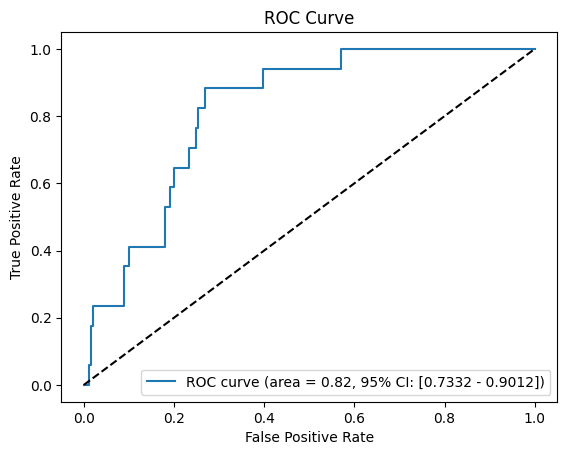

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# 读取数据
result = pd.read_csv('./val_result.csv')

gt = result.iloc[:, 1]
proba = result.iloc[:, 2]

# 计算并打印 AUC
# auc = roc_auc_score(gt, proba)
auc, ci_lower, ci_upper = calculate_auc_ci(gt, proba)
print(f'AUC: {auc:.4f}, 95% CI: [{ci_lower:.4f} - {ci_upper:.4f}]')
# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(gt, proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f}, 95% CI: [{ci_lower:.4f} - {ci_upper:.4f}])')
plt.plot([0, 1], [0, 1], 'k--')  # 对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

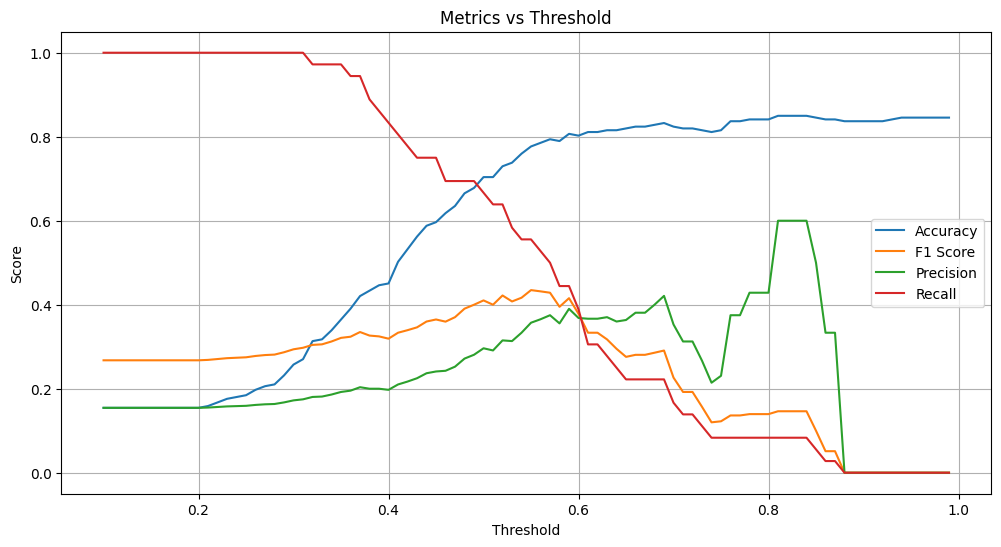

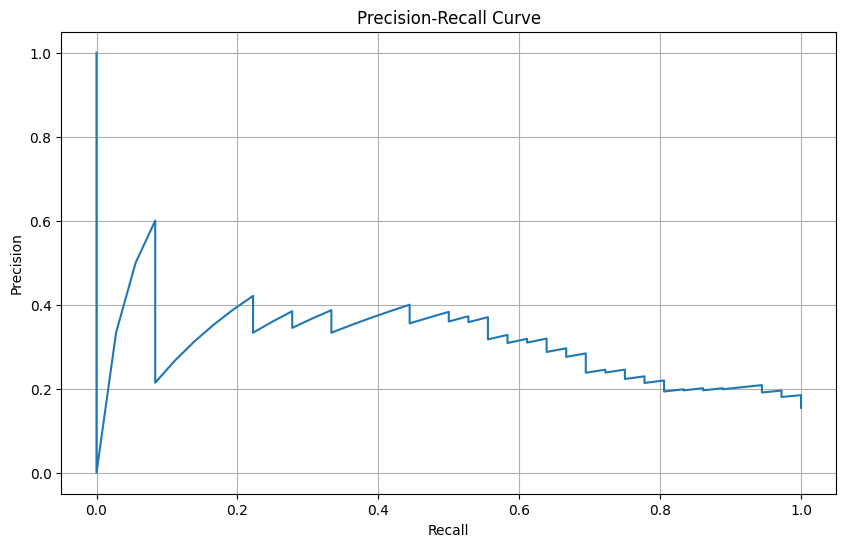

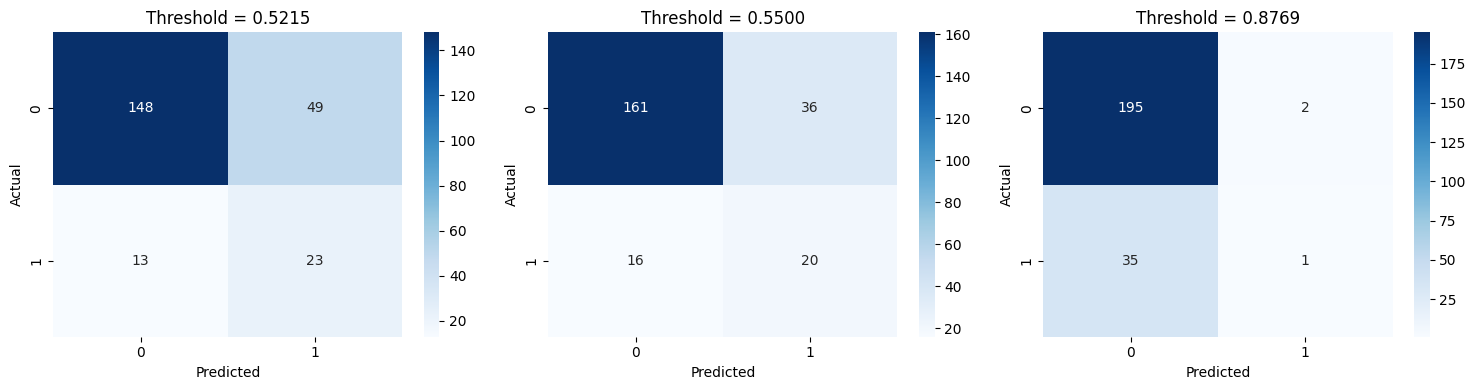


最优阈值及对应指标:
        Threshold  Accuracy  Precision  Recall      F1
Youden     0.5215    0.7339     0.3194  0.6389  0.4259
F1         0.5500    0.7768     0.3571  0.5556  0.4348
PR         0.8769    0.8412     0.3333  0.0278  0.0513

使用选定阈值的最终模型评估:0.5500
Accuracy: 0.7768
Precision: 0.3571
Recall: 0.5556
F1 Score: 0.4348


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns

def find_optimal_cutoff(y_true, y_prob):
    """
    计算并可视化多种方法下的最优阈值
    
    参数:
    y_true: 真实标签
    y_prob: 预测概率
    
    返回:
    dict: 包含不同方法的最优阈值
    """
    
    def plot_metrics_curve():
        """绘制不同指标随阈值变化的曲线"""
        thresholds = np.arange(0.1, 1, 0.01)
        accuracies = []
        f1_scores = []
        precisions = []
        recalls = []
        
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            accuracies.append(accuracy_score(y_true, y_pred))
            f1_scores.append(f1_score(y_true, y_pred))
            precisions.append(precision_score(y_true, y_pred))
            recalls.append(recall_score(y_true, y_pred))
        
        plt.figure(figsize=(12, 6))
        plt.plot(thresholds, accuracies, label='Accuracy')
        plt.plot(thresholds, f1_scores, label='F1 Score')
        plt.plot(thresholds, precisions, label='Precision')
        plt.plot(thresholds, recalls, label='Recall')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Metrics vs Threshold')
        plt.legend()
        plt.grid(True)
        # 保存pdf
        plt.savefig('metrics_vs_threshold.pdf')
        plt.show()
        
        return thresholds, accuracies, f1_scores, precisions, recalls
    
    def plot_pr_curve():
        """绘制PR曲线"""
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        # 保存pdf
        plt.savefig('precision_recall_curve.pdf')
        plt.show()
        return precision, recall, thresholds
    
    def plot_confusion_matrices(thresholds_to_plot):
        """绘制不同阈值下的混淆矩阵"""
        n = len(thresholds_to_plot)
        fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
        if n == 1:
            axes = [axes]
            
        for ax, threshold in zip(axes, thresholds_to_plot):
            y_pred = (y_prob >= threshold).astype(int)
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
            ax.set_title(f'Threshold = {threshold:.4f}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        plt.tight_layout()
        # 保存pdf
        plt.savefig('confusion_matrices.pdf')
        plt.show()
    
    # 1. Youden's J statistic (最大化 sensitivity + specificity - 1)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    optimal_j_idx = np.argmax(j_scores)
    optimal_j_threshold = thresholds[optimal_j_idx]
    
    # 2. 最大F1分数
    thresholds, accuracies, f1_scores, precisions, recalls = plot_metrics_curve()
    optimal_f1_idx = np.argmax(f1_scores)
    optimal_f1_threshold = thresholds[optimal_f1_idx]
    
    # 3. PR曲线阈值
    precision, recall, pr_thresholds = plot_pr_curve()
    # F1分数在PR空间中的最优点
    f1_scores_pr = 2 * (precision * recall) / (precision + recall)
    optimal_pr_idx = np.argmax(f1_scores_pr)
    optimal_pr_threshold = pr_thresholds[optimal_pr_idx-1] if optimal_pr_idx > 0 else 0
    
    # 绘制不同阈值下的混淆矩阵
    thresholds_to_plot = [optimal_j_threshold, optimal_f1_threshold, optimal_pr_threshold]
    plot_confusion_matrices(thresholds_to_plot)
    
    # 计算并打印各阈值下的详细指标
    results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1'])
    
    for method, threshold in [('Youden', optimal_j_threshold), 
                            ('F1', optimal_f1_threshold),
                            ('PR', optimal_pr_threshold)]:
        y_pred = (y_prob >= threshold).astype(int)
        results.loc[method] = [
            threshold,
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            f1_score(y_true, y_pred)
        ]
    
    print("\n最优阈值及对应指标:")
    print(results.round(4))
    
    return {
        'youden': optimal_j_threshold,
        'f1': optimal_f1_threshold,
        'pr': optimal_pr_threshold
    }

# 使用示例
def example_usage():
    # 假设已有预测概率和真实标签
    result = pd.read_csv('./kits_result.csv')
    y_true = result.iloc[:, 1]
    y_prob = result.iloc[:, 2]
    
    # 找到最优阈值
    optimal_thresholds = find_optimal_cutoff(y_true, y_prob)
    
    # 使用最优阈值进行预测
    threshold = optimal_thresholds['f1']  # 可以选择不同方法得到的阈值
    y_pred = (y_prob >= threshold).astype(int)
    
    # 输出最终模型评估指标
    print(f"\n使用选定阈值的最终模型评估:{threshold:.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

if __name__ == "__main__":
    example_usage()

In [ ]:
# 转换结果为 DataFrame
results_df = pd.DataFrame(results)

# 保存结果到 CSV 文件
results_df.to_csv('results_rad_lr.csv', index=False)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 定义 X_train, y_train, X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(feature_rad, label, test_size=0.3, random_state=42)
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_henan = pd.DataFrame(scaler.transform(henan_rad), index=henan_rad.index, columns=henan_rad.columns)
X_kits = pd.DataFrame(scaler.transform(kits_rad), index=kits_rad.index, columns=kits_rad.columns)
y_henan = henan_label.ravel()
y_kits = kits_label.ravel()
y_train = y_train.ravel()
y_test = y_test.ravel()
assert all(X_kits.index == y_kits.index)
assert all(X_henan.index == y_henan.index)

# 定义分类器
classifiers = [
    ('logistic_regression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('decision_tree', DecisionTreeClassifier(class_weight='balanced')),
    ('random_forest', RandomForestClassifier(class_weight='balanced')),
    ('suppport_vector_machine', SVC(class_weight='balanced', probability=True))
]

# 存储结果
results = []

# 创建管道和网格搜索
for k_num in range(20, 80, 5):
    for clf_name, clf in classifiers:
        # 定义特征选择器
        feature_selector = SelectKBest(mutual_info_classif, k=k_num)
        
        # 创建管道
        pipeline = Pipeline([
            ('feature_selection', feature_selector),
            ('classifier', clf)
        ])
        
        # 定义参数网格
        param_grid = {
            'logistic_regression': {
                'classifier__C': [0.001, 0.005, 0.01, 0.05, 0.1],  # 围绕0.01细化
                'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                # 增加额外的重要参数
                'classifier__max_iter': [200, 500, 1000]
            },
            'decision_tree': {
                'classifier__max_depth': [2, 3, 4, 5],  # 围绕3细化
                'classifier__min_samples_split': [3, 4, 5, 6, 7],  # 围绕5细化
                # 增加额外的重要参数
                'classifier__min_samples_leaf': [1, 2, 3],
                'classifier__criterion': ['gini', 'entropy']
            },
            'random_forest': {
                'classifier__n_estimators': [150, 200, 250, 300, 350],  # 围绕200-300细化
                'classifier__max_depth': [3, 4, 5, 6, 7, 8],  # 围绕3-7细化
                'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],  # 围绕2-10细化
                # 增加额外的重要参数
                'classifier__min_samples_leaf': [1, 2, 4],
                'classifier__max_features': ['sqrt', 'log2', None],

            },
            'suppport_vector_machine': {
                'classifier__C': [0.05, 0.1, 0.15, 0.2],  # 围绕0.1细化
                'classifier__kernel': ['linear', 'rbf'],
                # 增加额外的重要参数
                'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            }
        }
        
        # 根据分类器名称选择对应的参数网格
        current_param_grid = param_grid[clf_name]
        
        # 创建网格搜索
        grid_search = GridSearchCV(
            pipeline,
            param_grid=current_param_grid,
            cv=5,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            refit='roc_auc',
            n_jobs=-1
        )
        
        # 训练模型
        grid_search.fit(X_train, y_train)
        
        # 在验证集上评估
        y_val_pred = grid_search.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, grid_search.predict_proba(X_val)[:, 1])
        
        # 在外部验证集上评估
        y_henan_pred = grid_search.predict(X_henan)
        henan_accuracy = accuracy_score(y_henan, y_henan_pred)
        henan_precision = precision_score(y_henan, y_henan_pred)
        henan_recall = recall_score(y_henan, y_henan_pred)
        henan_f1 = f1_score(y_henan, y_henan_pred)
        henan_auc = roc_auc_score(y_henan, grid_search.predict_proba(X_henan)[:, 1])
        
        y_kits_pred = grid_search.predict(X_kits)
        kits_accuracy = accuracy_score(y_kits, y_kits_pred)
        kits_precision = precision_score(y_kits, y_kits_pred)
        kits_recall = recall_score(y_kits, y_kits_pred)
        kits_f1 = f1_score(y_kits, y_kits_pred)
        kits_auc = roc_auc_score(y_kits, grid_search.predict_proba(X_kits)[:, 1])
        
        # 存储结果
        results.append({
            'feature_num': k_num,
            'classifier': clf_name,
            'best_params': grid_search.best_params_,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'val_auc': val_auc,
            'henan_accuracy': henan_accuracy,
            'henan_precision': henan_precision,
            'henan_recall': henan_recall,
            'henan_f1': henan_f1,
            'henan_auc': henan_auc,
            'kits_accuracy': kits_accuracy,
            'kits_precision': kits_precision,
            'kits_recall': kits_recall,
            'kits_f1': kits_f1,
            'kits_auc': kits_auc
        })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results)

# 保存结果
results_df.to_csv('model_evaluation_results.csv', index=False)

# 找出性能最好的模型
best_model = results_df.loc[results_df['val_auc'].idxmax()]
print("Best Model Configuration:")
print(f"Feature Number: {best_model['feature_num']}")
print(f"Classifier: {best_model['classifier']}")
print(f"Best Parameters: {best_model['best_params']}")
print("\nValidation Set Performance:")
print(f"AUC: {best_model['val_auc']:.3f}")
print(f"Accuracy: {best_model['val_accuracy']:.3f}")
print("\nHenan External Validation Performance:")
print(f"AUC: {best_model['henan_auc']:.3f}")
print(f"Accuracy: {best_model['henan_accuracy']:.3f}")
print("\nKITS External Validation Performance:")
print(f"AUC: {best_model['kits_auc']:.3f}")
print(f"Accuracy: {best_model['kits_accuracy']:.3f}")

# 转换结果为 DataFrame
results_df = pd.DataFrame(results)
results_df.to_excel('results_rad.excel', index=False)

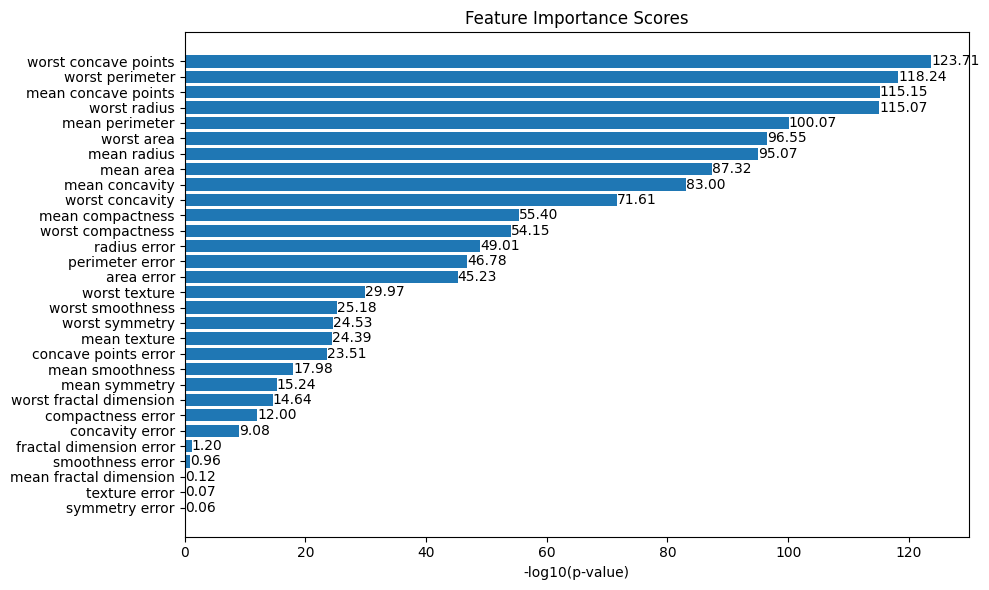

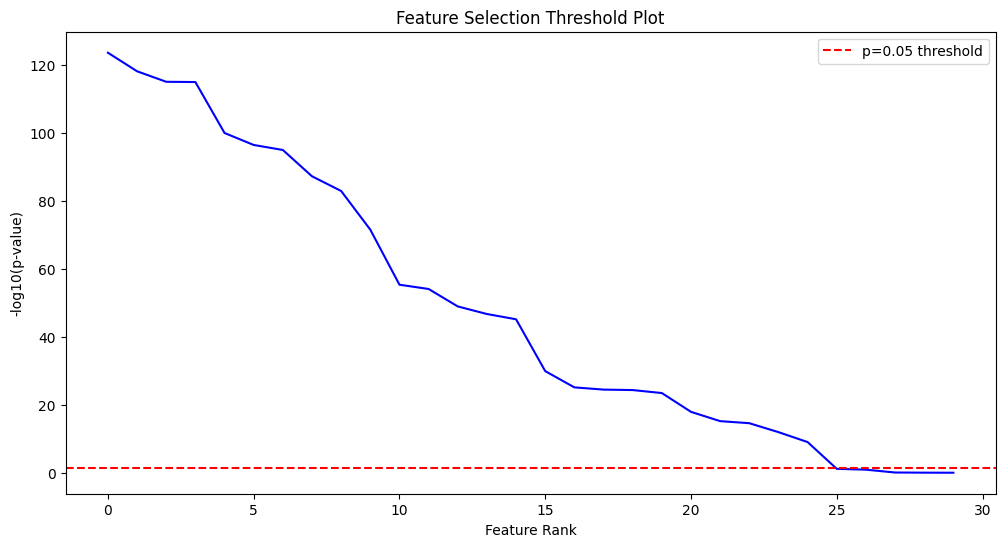

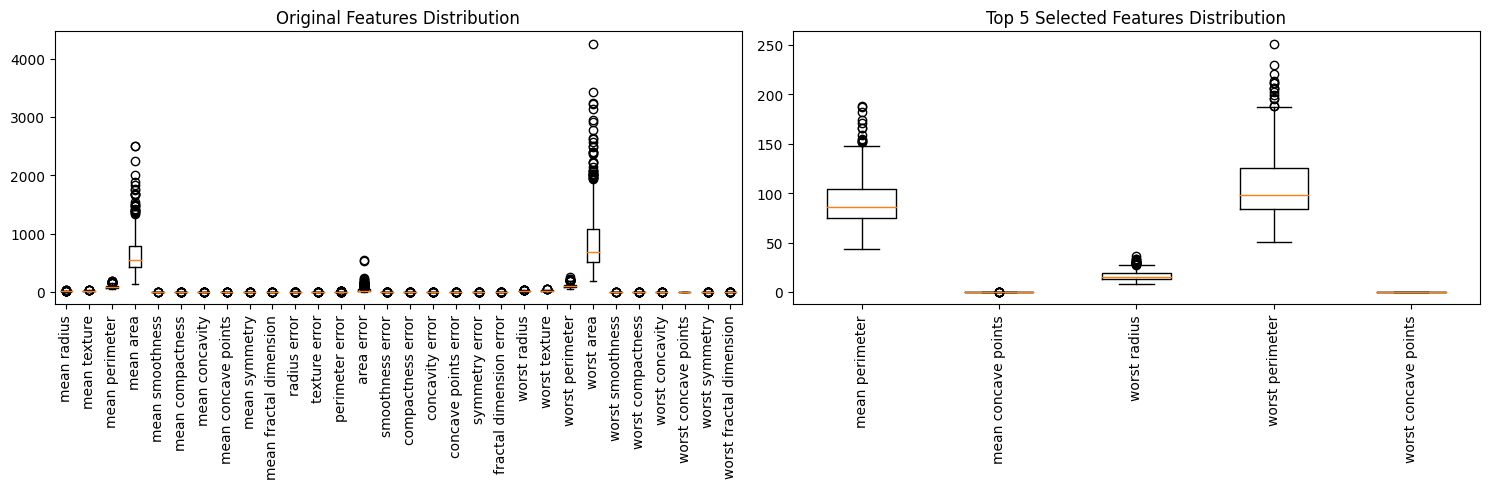

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

def plot_feature_scores(X, y, feature_names=None, k='all'):
    """
    绘制特征重要性分数图
    
    参数:
    X: 特征矩阵
    y: 目标变量
    feature_names: 特征名列表
    k: 选择的特征数量
    """
    # 如果没有提供特征名，则生成默认名称
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    # 计算特征得分
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    scores = -np.log10(selector.pvalues_)
    
    # 创建数据框
    scores_df = pd.DataFrame({
        'Feature': feature_names,
        'Score': scores
    })
    
    # 按分数排序
    scores_df = scores_df.sort_values('Score', ascending=True)
    
    # 绘图
    plt.figure(figsize=(10, 6))
    
    # 水平条形图
    bars = plt.barh(range(len(scores_df)), scores_df['Score'])
    
    # 设置y轴标签
    plt.yticks(range(len(scores_df)), scores_df['Feature'])
    
    # 在条形上添加具体数值
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, i, f'{width:.2f}', 
                ha='left', va='center', fontsize=10)
    
    plt.xlabel('-log10(p-value)')
    plt.title('Feature Importance Scores')
    plt.tight_layout()
    plt.show()

def plot_feature_selection_curve(X, y, feature_names=None):
    """
    绘制特征选择数量与得分的关系曲线
    """
    max_features = X.shape[1]
    scores = []
    
    for k in range(1, max_features + 1):
        selector = SelectKBest(score_func=f_classif, k=k)
        selector.fit(X, y)
        scores.append(-np.log10(selector.pvalues_[selector.get_support()]).mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_features + 1), scores, marker='o')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Average -log10(p-value)')
    plt.title('Feature Selection Score vs Number of Features')
    plt.grid(True)
    plt.show()

def plot_feature_heatmap(X, y, feature_names=None):
    """
    绘制特征相关性热图
    """
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    # 创建数据框
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y
    
    # 计算相关性矩阵
    corr = df.corr()
    
    # 绘制热图
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# 使用示例
def example_usage():
    # 生成示例数据
    np.random.seed(42)
    n_samples = 1000
    n_features = 10
    
    X = np.random.randn(n_samples, n_features)
    # 创建一些有意义的特征
    y = 1.5 * X[:,0] + 0.5 * X[:,1] + np.random.randn(n_samples) * 0.1
    y = y > np.median(y)  # 转换为二分类问题
    
    feature_names = [f'Feature_{i}' for i in range(n_features)]
    
    # 绘制三种不同的可视化
    plot_feature_scores(X, y, feature_names)
    plot_feature_selection_curve(X, y)
    plot_feature_heatmap(X, y, feature_names)

# 实际应用示例
def real_world_example():
    """
    使用真实数据集的示例
    """
    from sklearn.datasets import load_breast_cancer
    
    # 加载数据
    data = load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    
    # 1. 基础特征重要性图
    plot_feature_scores(X, y, feature_names)
    
    # 2. 带阈值线的特征选择
    plt.figure(figsize=(12, 6))
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    scores = -np.log10(selector.pvalues_)
    
    plt.plot(range(len(scores)), sorted(scores, reverse=True), 'b-')
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', 
                label='p=0.05 threshold')
    plt.xlabel('Feature Rank')
    plt.ylabel('-log10(p-value)')
    plt.title('Feature Selection Threshold Plot')
    plt.legend()
    plt.show()
    
    # 3. 特征选择前后的对比
    k = 5  # 选择前5个特征
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 原始特征分布
    ax1.boxplot(X)
    ax1.set_xticklabels(feature_names, rotation=90)
    ax1.set_title('Original Features Distribution')
    
    # 选择后的特征分布
    selected_features = feature_names[selector.get_support()]
    ax2.boxplot(X_selected)
    ax2.set_xticklabels(selected_features, rotation=90)
    ax2.set_title(f'Top {k} Selected Features Distribution')
    
    plt.tight_layout()
    plt.show()

# 绘制特征重要性图
real_world_example()

In [ ]:
# 选择classifier， feature selection and SHAP analysis

In [ ]:
from mrmr import mrmr_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 定义 X_train, y_train, X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(feature_5, label, test_size=0.3, random_state=42)
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_henan = pd.DataFrame(scaler.transform(henan_5), index=henan_5.index, columns=henan_5.columns)
X_kits = pd.DataFrame(scaler.transform(kits_5), index=kits_5.index, columns=kits_5.columns)
y_henan = henan_label
y_kits = kits_label
assert all(X_kits.index == y_kits.index)
assert all(X_henan.index == y_henan.index)

# 定义分类器
classifiers = [
    ('logistic_regression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('random_forest', RandomForestClassifier(class_weight='balanced')),
    ('gradient_boosting', GradientBoostingClassifier()),
    ('linear_svc', LinearSVC(max_iter=10000, class_weight='balanced'))
]

# 存储结果
results = []

# 创建管道和网格搜索
for k_num in [10, 20, 30, 40, 50]:
    for clf_name, clf in classifiers:
        feature_selectors = [
            ('mrmr', lambda: mrmr_classif(X_train, y_train, K=k_num)),
            ('select_kbest_mutual_info', SelectKBest(mutual_info_classif, k=k_num)),
            ('rfe', RFE(estimator=clf, n_features_to_select=k_num))
        ]

        for feature_name, feature_selector in feature_selectors:
            if feature_name == 'mrmr':
                selected_features = feature_selector()
                X_train_selected = X_train.loc[:, selected_features]
                X_val_selected = X_val.loc[:, selected_features]
                X_henan_selected = X_henan.loc[:, selected_features]
                X_kits_selected = X_kits.loc[:, selected_features]
            else:
                X_train_selected = X_train
                X_val_selected = X_val
                X_henan_selected = X_henan
                X_kits_selected = X_kits

            pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('feature_selection', feature_selector if feature_name != 'mrmr' else 'passthrough'),
                ('classifier', clf)
            ])

            param_grid = {}
            if clf_name == 'logistic_regression':
                param_grid['classifier__C'] = [0.01, 0.1, 1, 10]
            elif clf_name == 'random_forest':
                param_grid['classifier__n_estimators'] = [50, 100, 150, 200]
            elif clf_name == 'linear_svc':
                param_grid['classifier__C'] = [0.01, 0.1, 1, 10]

            search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=5,
                scoring='roc_auc',
                verbose=1,
                n_jobs=-1
            )
            search.fit(X_train_selected, y_train)

            # Validation 评估
            y_score = search.decision_function(X_val_selected) if clf_name == 'linear_svc' else search.predict_proba(X_val_selected)[:, 1]
            best_threshold, precision, recall = find_best_threshold_by_youden(y_val, y_score)
            auc = roc_auc_score(y_val, y_score)

            # Henan 和 Kits 数据集评估
            y_score_henan = search.decision_function(X_henan_selected) if clf_name == 'linear_svc' else search.predict_proba(X_henan_selected)[:, 1]
            y_score_kits = search.decision_function(X_kits_selected) if clf_name == 'linear_svc' else search.predict_proba(X_kits_selected)[:, 1]
            best_threshold_henan, precision_henan, recall_henan = find_best_threshold_by_youden(y_henan, y_score_henan)
            best_threshold_kits, precision_kits, recall_kits = find_best_threshold_by_youden(y_kits, y_score_kits)
            auc_henan = roc_auc_score(y_henan, y_score_henan)
            auc_kits = roc_auc_score(y_kits, y_score_kits)

            results.append({
                "k_num": k_num,
                "Feature Selection": feature_name,
                "Classifier": clf_name,
                "Best Params": search.best_params_,
                "Best CV AUC": search.best_score_,
                "Validation Youden": best_threshold,
                "Validation AUC ": auc,
                "Validation Precision": precision,
                "Validation Recall": recall,
                "Henan Youden": best_threshold_henan,
                "Henan AUC": auc_henan,
                "Henan Precision": precision_henan,
                "Henan Recall": recall_henan,
                "Kits Youden": best_threshold_kits,
                "Kits AUC": auc_kits,
                "Kits Precision": precision_kits,
                "Kits Recall": recall_kits
            })

# 转换结果为 DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('results_5.csv', index=False)

In [ ]:
from mrmr import mrmr_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 定义 X_train, y_train, X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(feature_ith, label, test_size=0.3, random_state=42)
# standardize the data
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
# X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
# X_henan = pd.DataFrame(scaler.transform(henan_5), index=henan_5.index, columns=henan_5.columns)
# X_kits = pd.DataFrame(scaler.transform(kits_5), index=kits_5.index, columns=kits_5.columns)
X_henan = henan_ith
X_kits = kits_ith
y_henan = henan_label
y_kits = kits_label
assert all(X_kits.index == y_kits.index)
assert all(X_henan.index == y_henan.index)

# 定义分类器
classifiers = [
    ('logistic_regression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('random_forest', RandomForestClassifier(class_weight='balanced')),
    ('gradient_boosting', GradientBoostingClassifier()),
    ('linear_svc', LinearSVC(max_iter=10000, class_weight='balanced'))
]

# 存储结果
results = []

# 创建管道和网格搜索
for k_num in [10, 20, 30, 40, 50]:
    for clf_name, clf in classifiers:
        feature_selectors = [
            ('mrmr', lambda: mrmr_classif(X_train, y_train, K=k_num)),
            ('select_kbest_mutual_info', SelectKBest(mutual_info_classif, k=k_num)),
            ('rfe', RFE(estimator=clf, n_features_to_select=k_num))
        ]

        for feature_name, feature_selector in feature_selectors:
            if feature_name == 'mrmr':
                selected_features = feature_selector()
                X_train_selected = X_train.loc[:, selected_features]
                X_val_selected = X_val.loc[:, selected_features]
                X_henan_selected = X_henan.loc[:, selected_features]
                X_kits_selected = X_kits.loc[:, selected_features]
            else:
                X_train_selected = X_train
                X_val_selected = X_val
                X_henan_selected = X_henan
                X_kits_selected = X_kits

            pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('feature_selection', feature_selector if feature_name != 'mrmr' else 'passthrough'),
                ('classifier', clf)
            ])

            param_grid = {}
            if clf_name == 'logistic_regression':
                param_grid['classifier__C'] = [0.01, 0.1, 1, 10]
            elif clf_name == 'random_forest':
                param_grid['classifier__n_estimators'] = [50, 100, 150, 200]
            elif clf_name == 'linear_svc':
                param_grid['classifier__C'] = [0.01, 0.1, 1, 10]

            search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=5,
                scoring='roc_auc',
                verbose=1,
                n_jobs=-1
            )
            search.fit(X_train_selected, y_train)

            # Validation 评估
            y_score = search.decision_function(X_val_selected) if clf_name == 'linear_svc' else search.predict_proba(X_val_selected)[:, 1]
            best_threshold, precision, recall = find_best_threshold_by_youden(y_val, y_score)
            auc = roc_auc_score(y_val, y_score)

            # Henan 和 Kits 数据集评估
            y_score_henan = search.decision_function(X_henan_selected) if clf_name == 'linear_svc' else search.predict_proba(X_henan_selected)[:, 1]
            y_score_kits = search.decision_function(X_kits_selected) if clf_name == 'linear_svc' else search.predict_proba(X_kits_selected)[:, 1]
            best_threshold_henan, precision_henan, recall_henan = find_best_threshold_by_youden(y_henan, y_score_henan)
            best_threshold_kits, precision_kits, recall_kits = find_best_threshold_by_youden(y_kits, y_score_kits)
            auc_henan = roc_auc_score(y_henan, y_score_henan)
            auc_kits = roc_auc_score(y_kits, y_score_kits)

            results.append({
                "k_num": k_num,
                "Feature Selection": feature_name,
                "Classifier": clf_name,
                "Best Params": search.best_params_,
                "Best CV AUC": search.best_score_,
                "Validation Youden": best_threshold,
                "Validation AUC ": auc,
                "Validation Precision": precision,
                "Validation Recall": recall,
                "Henan Youden": best_threshold_henan,
                "Henan AUC": auc_henan,
                "Henan Precision": precision_henan,
                "Henan Recall": recall_henan,
                "Kits Youden": best_threshold_kits,
                "Kits AUC": auc_kits,
                "Kits Precision": precision_kits,
                "Kits Recall": recall_kits
            })

# 转换结果为 DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('results_ith.csv', index=False)